In [262]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap

In [263]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv", "Fuzzy_dataset_SONATA")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,dt_d0,dt_d1,dt_d2,dt_d3,dt_d4,dt_d5,dt_d6,dt_d7,name,class,dataset,type,Label
0,0.369422,0.078324,0.000444,0.009978,0.724212,0.014852,0.008606,0.015570,0.009878,0.001069,0.011646,0.112122,0.257314,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.453125,0.025104,0.000232,0.009977,0.045600,0.019498,0.001095,0.011275,0.009880,0.009658,0.009361,0.009878,0.000904,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,0.343750,0.000896,0.000248,0.009981,0.009991,0.009826,0.000248,0.000808,0.001119,0.000480,0.001412,0.000899,0.000248,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,0.328125,0.008395,0.000234,0.009978,0.047617,0.038203,0.027087,0.009841,0.009859,0.009885,0.007653,0.000234,0.006513,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.375000,0.038187,0.000241,0.009978,0.036785,0.009870,0.000475,0.000475,0.034847,0.000475,0.000475,0.000241,0.000475,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135665,0.328125,0.078125,0.000242,0.008995,0.799798,0.001008,0.001246,0.000242,0.000242,0.149000,0.001974,0.159987,0.219917,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135666,0.187500,0.000000,0.002922,0.049999,0.013848,0.002922,0.002922,0.002922,0.002922,0.003930,0.004168,0.003930,0.003930,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135667,0.296875,0.015625,0.000468,0.009935,0.019970,0.009935,0.009935,0.009935,0.003868,0.009935,0.018993,0.009418,0.000468,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135668,0.312500,0.000000,0.000250,0.009935,0.009935,0.000718,0.005135,0.000718,0.000718,0.000718,0.000718,0.000718,0.000250,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0


In [264]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [265]:
from sklearn.preprocessing import StandardScaler, RobustScaler

df_original = df.copy()

feature_columns= list(set(df.columns.to_list()).difference(["name", "class", "dataset", "type", "Label"]))

for col in feature_columns:
    scaler = RobustScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
    df.loc[:, df.columns == col] = scaler.transform(df.loc[:, df.columns == col])

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,dt_d0,dt_d1,dt_d2,dt_d3,dt_d4,dt_d5,dt_d6,dt_d7,name,class,dataset,type,Label
0,0.071447,0.802552,15.392904,-0.036750,0.866375,0.679258,0.752510,1.520016,0.739186,-0.745310,0.336812,12.294366,5.007122,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.666667,0.121326,-0.763636,-0.038113,0.007093,1.187873,-0.080271,1.073441,0.739357,0.103380,0.088818,1.009430,-0.016261,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,-0.111111,-0.188528,0.454545,-0.034453,-0.037996,0.129111,-0.174169,-0.014896,-0.183885,-0.803486,-0.773887,0.018311,-0.029114,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,-0.222222,-0.092542,-0.600000,-0.036783,0.009647,3.235510,2.801496,0.924378,0.737136,0.125780,-0.096581,-0.055051,0.093618,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.111111,0.288797,-0.090909,-0.036783,-0.004068,0.133925,-0.149005,-0.049479,3.370414,-0.803981,-0.875589,-0.054314,-0.024667,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135665,-0.222222,0.800000,0.000000,-0.848121,0.962084,-0.836248,-0.063519,-0.073699,-0.276325,13.871166,-0.712881,17.577432,4.274467,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135666,-1.222222,-0.200000,204.363636,32.986819,-0.033112,-0.626742,0.122281,0.204933,0.006080,-0.462615,-0.474797,0.352859,0.043019,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135667,-0.444444,0.000000,17.236364,-0.072595,-0.025360,0.140993,0.899818,0.934110,0.105776,0.130718,1.134192,0.958606,-0.024803,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135668,-0.333333,-0.200000,0.618182,-0.072595,-0.038067,-0.867986,0.367661,-0.024194,-0.226150,-0.779953,-0.849195,-0.001632,-0.029072,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0


In [266]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [267]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		12682		5436
Attack		12682		5436


In [268]:
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

Deep Neural Network

In [269]:
import keras
from keras import layers
# from tensorflow import keras
# from keras import layers

dnn = keras.models.Sequential(
    [
        keras.Input(shape=(len(X_train.columns),), name="input"),
        layers.Dense(23, activation='relu', name="layer_1"),
        layers.Dense(13, activation='relu', name="layer_2"),
        layers.Dense(7, activation='relu', name="layer_3"),
        layers.Dense(1, activation='sigmoid', name="output")
    ]
)



dnn.compile(
    optimizer="adam",  # Optimizer rmsprop
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.FalseNegatives()],
)

val_percent = int(len(y_train) * 0.1)
X_val = X_train.sample(val_percent, random_state=0) # X_train[-val_percent:]
y_val = y_train.loc[X_val.index] # y_train[-val_percent:]
X_train = X_train.loc[~X_train.index.isin(X_val)] # X_train[:-val_percent]
y_train = y_train.loc[~y_train.index.isin(X_val)] # y_train[:-val_percent]

dnn.fit(
    X_train,
    y_train,
    batch_size=100,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
)

# results = dnn.evaluate(X_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

Epoch 1/10
793/793 [==============================] - 1s 1ms/step - loss: 3.9329 - binary_accuracy: 0.9279 - recall_29: 0.9628 - false_negatives_29: 472.0000 - val_loss: 0.1353 - val_binary_accuracy: 0.9826 - val_recall_29: 0.9709 - val_false_negatives_29: 37.0000
Epoch 2/10
793/793 [==============================] - 1s 952us/step - loss: 0.0736 - binary_accuracy: 0.9884 - recall_29: 0.9881 - false_negatives_29: 151.0000 - val_loss: 0.0604 - val_binary_accuracy: 0.9925 - val_recall_29: 0.9866 - val_false_negatives_29: 17.0000
Epoch 3/10
793/793 [==============================] - 1s 977us/step - loss: 0.0427 - binary_accuracy: 0.9928 - recall_29: 0.9910 - false_negatives_29: 114.0000 - val_loss: 0.0538 - val_binary_accuracy: 0.9921 - val_recall_29: 0.9851 - val_false_negatives_29: 19.0000
Epoch 4/10
793/793 [==============================] - 1s 986us/step - loss: 0.0625 - binary_accuracy: 0.9908 - recall_29: 0.9916 - false_negatives_29: 106.0000 - val_loss: 0.0502 - val_binary_accuracy:

In [270]:
pred_train = np.round(dnn.predict(X_train))

f1_scores = f1_score(y_train, pred_train, average='weighted')
print("Training F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

pred_test = np.round(dnn.predict(X_test))

f1_scores = f1_score(y_test, pred_test, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred_test)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1:  0.9942(+/- 0.0000)
Testing F1:  0.9931(+/- 0.0000)
Kappa score:  0.9862(+/- 0.0000)


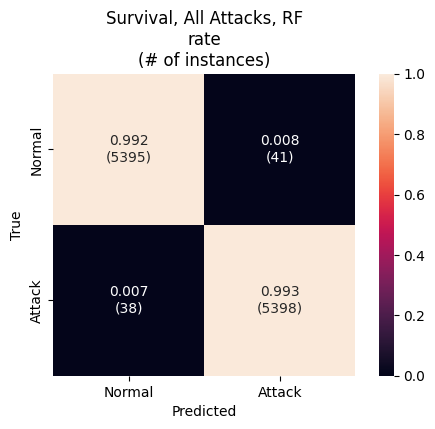

In [10]:
from plot_tools import plot_confusion_matrix

plot_confusion_matrix(y_test, pred_test, "Survival, All Attacks, RF\nrate\n(# of instances)")

In [11]:
import shap

exp = shap.KernelExplainer(dnn, data=X_train.sample(100, random_state=1))
print(exp.expected_value)

[0.51894764]


In [12]:
from shap_tools import *


# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
# assert np.abs(exp.model.predict(X_train) - dnn.predict_proba(X_train)).max() < 1e-4

shap_all = get_explanation(exp, X_train, 600)

# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs((shap_all.base_values + shap_all.values).sum(1) - clf.predict_proba(X_train)).max() < 1e-4

# print(len(X_train.loc[y_train != pred]))
# print(len(X_train.loc[y_train == pred]))
# shap_false = get_explanation(exp, X_train.loc[y_train != pred])
# shap_FP = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 1)])
# shap_FN = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 0)])
# shap_true = get_explanation(exp, X_train.loc[y_train == pred])
# shap_TP = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 1)])
# shap_TN = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 0)])

100%|██████████| 600/600 [06:42<00:00,  1.49it/s]


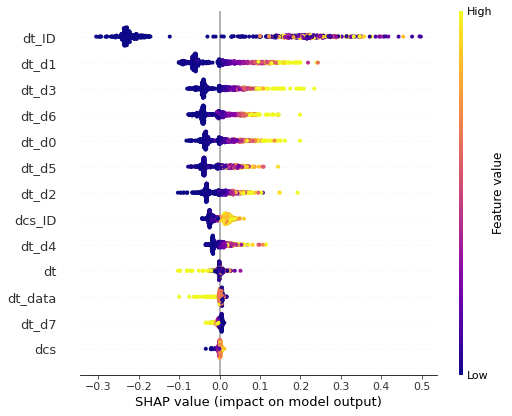

In [13]:
plot_beeswarm(shap_all)

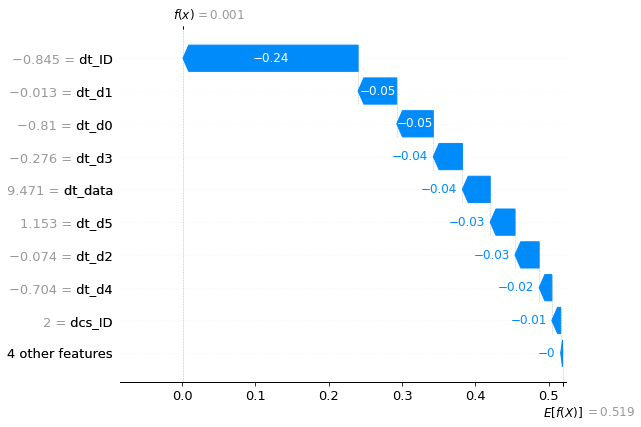

In [14]:
plot_waterfall(shap_all, 0)

In [15]:
plot_force(shap_all)

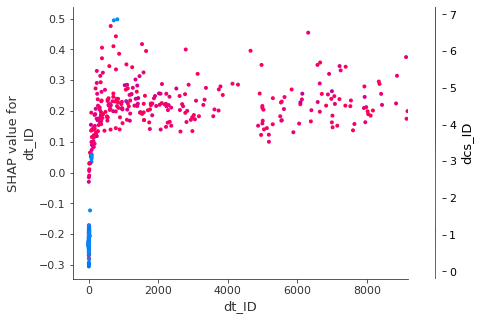

In [16]:
plot_dependence(shap_all, "dt_ID", "dcs_ID", xmax="percentile(99)")

In [17]:
dnn_layer_1 = keras.Model(inputs=dnn.input, outputs=dnn.get_layer("layer_3").output)

dnn_layer_1.predict(X_train)

array([[  2.8035035,   0.       ,   0.       ,   3.9883833,   0.       ],
       [  0.       ,   0.       ,   0.       ,  10.096009 ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   3.4852576,   0.       ],
       ...,
       [  0.       ,  22.874123 ,   0.       ,   0.       ,  22.220098 ],
       [  0.       , 338.0699   ,   0.       ,   0.       ,  29.941309 ],
       [  0.       ,  28.184793 ,   0.       ,   0.       ,   6.2021675]],
      dtype=float32)

In [18]:
exp_layer_1 = shap.KernelExplainer(dnn_layer_1, data=X_train.sample(100, random_state=1))

In [19]:
shap_all_layer_1 = get_explanation(exp_layer_1, X_train, 100)

100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


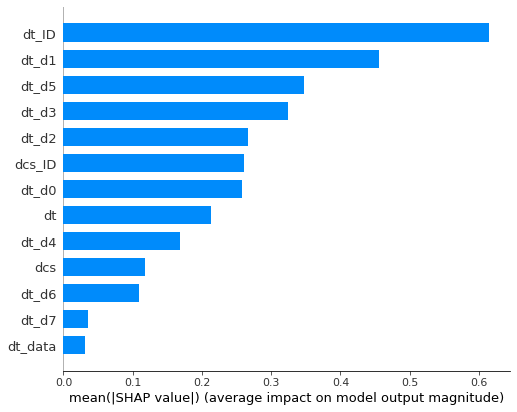

In [20]:
# print(shap_all_layer_1)
shap.summary_plot(shap_all_layer_1, X_test, plot_type="bar")